In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install pmdarima -q
#from pmdarima.arima import ADFTest



     |████████████████████████████████| 1.5MB 5.0MB/s 
     |████████████████████████████████| 9.5MB 16.3MB/s 
     |████████████████████████████████| 2.1MB 52.2MB/s 


In [ ]:
from pmdarima.arima import auto_arima

# **Переменные**

In [ ]:
cpi = "month"
reg_names = ['SFO']
data_do = "2020-12-01"
train_do = "2019-01-01"

mes = (pd.to_datetime(data_do).to_period('M') - pd.to_datetime(train_do).to_period('M')).n+1
result_rmse = pd.DataFrame(columns=['month/year', 'reg_names', 'data_do', 'train_do', 'mes', 'method', 'rmse'])

In [ ]:
from google.colab import files
files.upload()

Saving cpi_reg.xls to cpi_reg.xls
Saving RC_2002-2020.xlsx to RC_2002-2020.xlsx


{'RC_2002-2020.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00r=+<\x96\x01\x00\x00P\x06\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [ ]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)

In [ ]:
data.tail()

,RF,SFO,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,...,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,SAH,ZAB,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01,99.93,99.98,100.09,99.77,99.99,100.1,99.86,99.85,99.89,99.69,100.18,99.79,99.96,99.94,99.95,99.99,99.91,99.74,99.79,99.91,99.77,99.68,99.9,99.89,99.71,99.75,99.93,99.86,99.73,99.83,100.48,99.92,99.8,100.19,100.2,99.93,99.72,99.89,100.13,99.91,...,100.07,100.07,99.84,99.73,100.06,100.02,99.89,99.76,99.86,100.14,99.83,100.03,99.98,99.84,99.78,100.11,100.02,99.68,99.76,99.88,99.87,100.34,99.73,100.10,99.98,100.73,99.71,99.86,100.27,99.95,100.56,99.41,99.95,100.27,100.19,99.99,99.88,100.31,100.58,99.61
2020-10-01,100.43,100.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.05,100.40,100.42,100.46,100.38,100.57,100.35,100.57,100.68,100.22,100.30,NaN,100.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,100.71,100.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.84,100.63,100.92,101.52,101.01,100.81,100.56,100.86,100.87,100.34,100.64,NaN,100.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,100.83,100.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.71,100.91,100.81,100.43,100.89,100.82,100.71,100.06,100.81,100.73,100.80,NaN,100.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,100.67,100.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.31,100.64,100.69,100.66,100.58,100.51,100.73,100.38,100.70,100.41,100.56,NaN,100.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# for ML
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')
data['month'] = pd.DatetimeIndex(data.index).month

train = data[data.index < train_do]
test = data[data.index >= train_do]

# **ARIMA**

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=261.834, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=218.492, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=173.737, Time=0.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=263.359, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=173.884, Time=0.77 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=172.460, Time=1.42 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=168.217, Time=3.25 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=167.371, Time=2.64 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=170.770, Time=1.89 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=172.216, Time=2.10 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=148.019, Time=6.81 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=5.68 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=in

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671


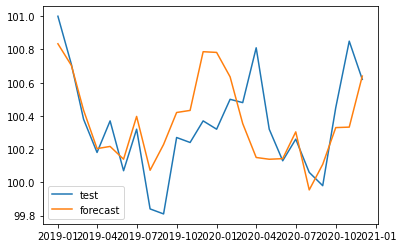

In [ ]:
# find best params for ARIMA
stepwise_model = auto_arima(train[reg_names], test='adf', start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, 
                                D=1, d=1, max_d=4, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion = 'aic')
#                               out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names], label="test")
plt.plot(future_forecast[reg_names], label="forecast")
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

result = pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])
result_arima = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMA', 'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arima, ignore_index = True) 
result_rmse



# **ARIMAX**

In [ ]:
exogenous_features = ['month', 'curs']

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=146.650, Time=2.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=247.238, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=190.983, Time=0.71 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=151.819, Time=0.92 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=145.888, Time=1.76 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=184.483, Time=1.34 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=143.251, Time=4.19 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=159.900, Time=2.96 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=140.052, Time=7.58 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=141.668, Time=6.69 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=142.940, Time=4.21 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=147.883, Time=4.89 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=141.949, Time=8.13 sec
 ARIMA(1,1,2)(2,1,2)[12]             

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908


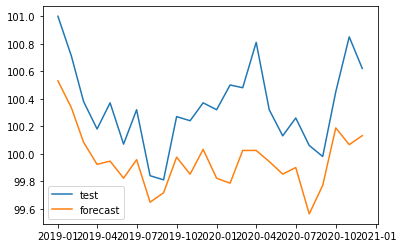

In [ ]:

# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], test='adf', start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, information_criterion = 'aic')
#                            out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'aicc')
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

plt.plot(test[reg_names], label="test")
plt.plot(future_forecast[reg_names], label="forecast")
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])
result_arimax = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ARIMAX', 
                'rmse': mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5} 
result_rmse = result_rmse.append(result_arimax, ignore_index = True) 
result_rmse

In [ ]:
data.head()

,SFO,curs,month
date,,,
2002-01-01,102.7,30.472715,1
2002-02-01,101.1,30.805700,2
2002-03-01,101.1,31.064267,3
2002-04-01,101.0,31.173586,4
2002-05-01,101.3,31.254884,5


# **Feature Engineering**

In [ ]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values

for i in [1, 6, 12]:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values

data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-6,t-12,month
date,,,,,,
2003-01-01,31.816165,102.50,101.30,101.10,102.70,1
2003-02-01,31.698979,101.93,102.50,100.10,101.10,2
2003-03-01,31.453290,101.19,101.93,100.80,101.10,3
2003-04-01,31.211786,101.07,101.19,101.30,101.00,4
2003-05-01,30.907055,100.62,101.07,101.30,101.30,5
...,...,...,...,...,...,...
2020-08-01,73.798110,100.06,100.26,100.50,99.84,8
2020-09-01,75.727986,99.98,100.06,100.48,99.81,9
2020-10-01,77.663548,100.45,99.98,100.81,100.27,10


In [ ]:
# tmp = pd.DataFrame()
# tmp['a'] = np.array([1,2,3,4,5,6,7,8])
# tmp_r = tmp['a'].rolling(window=3, min_periods=0)
# tmp_r.mean().shift(1)

In [ ]:
# # df=data_lags.copy()
# df = pd.DataFrame()
# df['t'] = np.array([1,2,3,4,5,6,7,8])

# df.reset_index(drop=False, inplace=True)
# lag_features = ["t"]
# window1 = 6

# df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
# df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
# df_mean_3m

In [ ]:
df=data_lags.copy()
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

# df.fillna(df.mean(), inplace=True)
df.dropna(axis=0, inplace=True)

df.set_index("date", drop=True, inplace=True)


In [ ]:
data = df.copy()
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()

X = data.drop(['t'], axis=1).values
y = data[['t']].values.ravel()

In [ ]:
data.columns

Index(['curs', 't', 't-1', 't-6', 't-12', 'month', 't_mean_lag3',
       't_mean_lag6', 't_mean_lag12', 't_std_lag3', 't_std_lag6',
       't_std_lag12', 'curs_mean_lag3', 'curs_mean_lag6', 'curs_mean_lag12',
       'curs_std_lag3', 'curs_std_lag6', 'curs_std_lag12'],
      dtype='object')

# **SCALER**

In [ ]:
# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_m = scaler.transform(X_train)
X_test_m = scaler.transform(X_test)

In [ ]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])

In [ ]:
X_train.shape

(190, 17)

In [ ]:
my_cv = TimeSeriesSplit(n_splits=16).split(X_train)

In [ ]:
for n, i in enumerate(my_cv):
  print(i)
  print(i[1].shape)
  if n == 0:
    break

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]))
(11,)


# **Ridge (l2-regularisation)**

In [ ]:
np.linspace(0, 10, 21)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [ ]:
%%time
param_grid = {'alpha': np.linspace(0, 10, 21)}
my_cv = TimeSeriesSplit(n_splits=16).split(X_train)

GSRidge = GridSearchCV(Ridge(normalize='true'), param_grid, cv=my_cv)
GSRidge.fit(X_train, y_train)
print("Training set score: {:.2f}".format(GSRidge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(GSRidge.score(X_test, y_test)))

forecast = GSRidge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Training set score: 0.44
Test set score: 0.26
rmse: 0.25488
normed rmse: 0.25%
CPU times: user 874 ms, sys: 731 ms, total: 1.6 s
Wall time: 835 ms


In [ ]:
"""
param_grid = {'alpha': np.linspace(0, 10, 21)}
pipe = make_pipeline(MinMaxScaler(), Ridge())
my_cv = TimeSeriesSplit(n_splits=16).split(X_train)
GSRidge = GridSearchCV(pipe, param_grid, cv=my_cv)
GSRidge.fit(X_train, y_train)
print("Training set score: {:.2f}".format(GSRidge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(GSRidge.score(X_test, y_test)))

forecast = GSRidge.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))
"""

In [ ]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result_Ridge = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Ridge', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Ridge, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.254881


# **Lasso (l1-regularisation)**

In [ ]:
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_m, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train_m, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test_m, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test_m)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.45
Test set score: 0.34
Number of features used: 5
rmse: 0.23993
normed rmse: 0.24%


In [ ]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result_Lasso = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Lasso', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_Lasso, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.254881
3,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.239931


# **ElasticNet (l1+l2-regularisation)**

In [ ]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.5f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.45
Test set score: 0.15
Number of features used: 6
rmse: 0.27315
normed rmse: 0.27%


In [ ]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result_ElasticNet = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'ElasticNet', 
                'rmse': mean_squared_error(y_test, forecast) ** 0.5} 
result_rmse = result_rmse.append(result_ElasticNet, ignore_index = True) 
result_rmse

,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,Ridge,0.254881
3,month,[SFO],2020-12-01,2019-01-01,24,Lasso,0.239931
4,month,[SFO],2020-12-01,2019-01-01,24,ElasticNet,0.273152


# **Plot_features**

In [ ]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')


In [ ]:
def plot_features_GS(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.best_estimator_.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')

# **GSRF**

In [ ]:
param_grid = {'n_estimators': [1, 10, 30, 50],
              'max_depth' : [1, 3, 5, 7, 10]}

my_cv = TimeSeriesSplit(n_splits=16).split(X_train)
GSRF = GridSearchCV(RandomForestRegressor(), param_grid, cv=my_cv)
GSRF.fit(X_train, y_train)
for train_index, test_index in my_cv:
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

print("Best parameters: {}".format(GSRF.best_params_))
print("Best estimator:\n{}".format(GSRF.best_estimator_))

# make predictions
GSRF_forecast = GSRF.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(GSRF_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSRF_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSRF_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSRF.score(X_test, y_test)))

result['GSRF']=pd.DataFrame(np.array(GSRF_forecast), index = test.index, columns=['GSRF'])

result_GSRF = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSRF', 
                'rmse': mean_squared_error(y_test, GSRF_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSRF, ignore_index = True) 
result_rmse


In [ ]:
plot_features_GS(GSRF)

# **Grid Search XGB**

Parameter grid:
{'max_depth': [1, 2, 3, 5, 10], 'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
Test set score: 0.36
Best parameters: {'max_depth': 3, 'n_estimators': 100}
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)
rmse: 0.2367
normed rmse: 0.2358%
Accuracy on training set: 0.925
Accuracy on test set: 0.358


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,GSXGB,0.236655


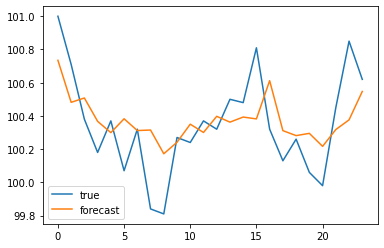

In [ ]:
param_grid = {'max_depth': [1, 2, 3, 5, 10],
              'n_estimators': [1, 10, 50, 100, 200, 300, 500]}
print("Parameter grid:\n{}".format(param_grid))
my_cv = TimeSeriesSplit(n_splits=16).split(X_train)

GSXGB = GridSearchCV(XGBRegressor(objective ='reg:squarederror'), param_grid, cv=my_cv)
GSXGB.fit(X_train, y_train, verbose=False)

print("Test set score: {:.2f}".format(GSXGB.score(X_test, y_test)))
print("Best parameters: {}".format(GSXGB.best_params_))
print("Best estimator:\n{}".format(GSXGB.best_estimator_))

# make predictions
GSXGB_forecast = GSXGB.predict(X_test)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSXGB_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSXGB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSXGB.score(X_test, y_test)))

result['GSXGB']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB'])

result_GSXGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB', 
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5} 
result_rmse = result_rmse.append(result_GSXGB, ignore_index = True) 
result_rmse

In [ ]:
plot_features_GS(GSXGB)

NameError: ignored

In [ ]:
data.columns

Index(['curs', 't', 't-1', 't-6', 't-12', 'month', 't_mean_lag3',
       't_mean_lag6', 't_mean_lag12', 't_std_lag3', 't_std_lag6',
       't_std_lag12', 'curs_mean_lag3', 'curs_mean_lag6', 'curs_mean_lag12',
       'curs_std_lag3', 'curs_std_lag6', 'curs_std_lag12'],
      dtype='object')

In [ ]:
def window_predict(model):  
  data_for_window = data.reset_index(drop=True).copy()
  # model = GSXGB

  t_new = model.predict(data_for_window.iloc[-24].values[np.arange(len(X_test[0])+1) != 1].reshape(1,-1))
  # print(t_new[0])

  for i in range(24, 1, -1):
    
    data_for_window.at[len(data_for_window)-i, 't'] = t_new[0]

    data_for_window.at[len(data_for_window)-i+1, 't-1'] = data_for_window.at[len(data_for_window)-i-0, 't']
    data_for_window.at[len(data_for_window)-i+1, 't-6'] = data_for_window.at[len(data_for_window)-i-5, 't']
    data_for_window.at[len(data_for_window)-i+1, 't-12'] = data_for_window.at[len(data_for_window)-i-11, 't']

    data_for_window.at[len(data_for_window)-i+1, 't_mean_lag3'] = data_for_window.loc[(len(data_for_window)-i-2):(len(data_for_window)-i-0), 't'].mean()
    data_for_window.at[len(data_for_window)-i+1, 't_mean_lag6'] = data_for_window.loc[(len(data_for_window)-i-5):(len(data_for_window)-i-0), 't'].mean()
    data_for_window.at[len(data_for_window)-i+1, 't_mean_lag12'] = data_for_window.loc[(len(data_for_window)-i-11):(len(data_for_window)-i-0), 't'].mean()

    data_for_window.at[len(data_for_window)-i+1, 't_std_lag3'] = data_for_window.loc[(len(data_for_window)-i-2):(len(data_for_window)-i-0), 't'].std()
    data_for_window.at[len(data_for_window)-i+1, 't_std_lag6'] = data_for_window.loc[(len(data_for_window)-i-5):(len(data_for_window)-i-0), 't'].std()
    data_for_window.at[len(data_for_window)-i+1, 't_std_lag12'] = data_for_window.loc[(len(data_for_window)-i-11):(len(data_for_window)-i-0), 't'].std()
    # print(len(data_for_window)-i+1)

    t_new = model.predict(data_for_window.iloc[-i+1].values[np.arange(len(X_test[0])+1) != 1].reshape(1,-1))
    # print(-i+1)

  return data_for_window.loc[len(data_for_window)-24:, 't'].values

In [ ]:
window_predict(GSXGB)

array([100.73468781, 100.52423859, 100.3842392 , 100.38998413,
       100.4066391 , 100.40374756, 100.4094162 , 100.37042999,
       100.38249969, 100.51979828, 100.57836914, 100.58583069,
       100.46792603, 100.44301605, 100.45988464, 100.44806671,
       100.44806671, 100.41181183, 100.43308258, 100.33538055,
       100.36667633, 100.48823547, 100.52719879, 100.62      ])

rmse: 0.2674
normed rmse: 0.2664%
Accuracy on training set: 0.925
Accuracy on test set: 0.358


,month/year,reg_names,data_do,train_do,mes,method,rmse
0,month,[SFO],2020-12-01,2019-01-01,24,ARIMA,0.254671
1,month,[SFO],2020-12-01,2019-01-01,24,ARIMAX,0.429908
2,month,[SFO],2020-12-01,2019-01-01,24,GSXGB,0.236655
3,month,[SFO],2020-12-01,2019-01-01,24,GSXGB,0.267367
4,month,[SFO],2020-12-01,2019-01-01,24,GSXGB_window,0.267367
5,month,[SFO],2020-12-01,2019-01-01,24,GSXGB_window,0.267367


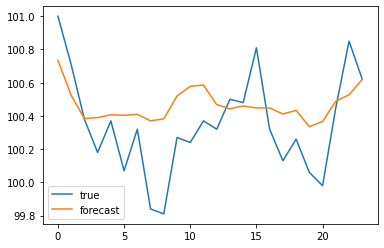

In [ ]:
# GSXGB_forecast = GSXGB.predict(X_test)
GSXGB_forecast = window_predict(GSXGB)
plt.plot(y_test, label='true')
plt.plot(GSXGB_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, GSXGB_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, GSXGB_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(GSXGB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(GSXGB.score(X_test, y_test)))

result['GSXGB_window']=pd.DataFrame(np.array(GSXGB_forecast), index = test.index, columns=['GSXGB_window'])

result_GSXGB = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'GSXGB_window', 
                'rmse': mean_squared_error(y_test, GSXGB_forecast) ** 0.5} 

result_rmse = result_rmse.append(result_GSXGB, ignore_index = True) 
result_rmse

# **Blend weight**

In [ ]:
result_rmse1 = result_rmse[(result_rmse.method != 'ARIMA') & (result_rmse.method != 'ARIMAX')]

result_rmse1['weight'] = 1/result_rmse1['rmse']/(1/result_rmse1['rmse']).sum()

meta_X = result_rmse1['weight']
meta_Y = result.drop(['y_test', 'ARIMA', 'ARIMAX'], axis=1)
a = np.array(meta_X)
b = np.array(meta_Y)
meta_blend = (np.sum(a * b, axis = 1))

result['Blend']=pd.DataFrame(np.array(meta_blend), index = test.index, columns=['Blend'])
result_Blend = {'month/year': cpi, 'reg_names': reg_names, 'data_do': data_do, 'train_do': train_do, 'mes': mes, 'method': 'Blend', 
                'rmse': mean_squared_error(y_test, meta_blend) ** 0.5} 
result_rmse = result_rmse.append(result_Blend, ignore_index = True)

# **Diebold-Mariano**

In [ ]:
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.

def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return' , 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [ ]:
actual_lst = result['y_test']
pred1_lst = result['ARIMAX']
pred2_lst = result['Blend']
h = test.shape[0] - 1

dm_test(actual_lst, pred1_lst, pred2_lst, h = h, crit="MSE", power = 2)

# **Results**

In [ ]:
result

In [ ]:
result.plot(figsize=(20, 7))
result_rmse